# Data Augumentation

La data augmentation è un passaggio fondamentale quando si addestra un modello, soprattutto se si trattano dei dataset ridotti. Noi non andremo ad aumentare la grandezza del dataset, ma modificheremo il suono dei comandi per rendere il modello più robusto.

Nel nostro caso, pur utilizzando dei livelli convolutivi, non è possibile replicare la stessa data augmentation delle immagini. È vero che stiamo utilizzando degli spettrogrammi, i quali possono essere visualizzati come immagini, ma è vero anche che non lo sono propriamente. Di fatto ciò è possibile data la loro struttura matriciale, ma, come spiegato in precedenza, gli assi indicano l'ampiezza e la fase dell'audio, che non sono paragonabili ai valori di un'immagine.

La data augmentation per noi è il fulcro del nostro progetto, perchè qui risiede la nostra idea innovativa. Abbiamo preso un dataset formato da 14 audio di rumori ambientali differenti, e li applicheremo ai nostri audio originali. In questo modo il modello risultante dall'allenamento su questi dati potrebbe essere utilizzato anche in casi reali, dove sappiamo che l'audio potrebbe presentare occlusioni, distorsioni, o altri tipi di problemi.

In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Audio
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

## Importazione dei dataset
Importiamo sia i dataset contenenti gli audio dei comandi, sia il dataset con i rumori. Dividiamo il primo in set di allenamento e validazione e per finire salviamo le etichette di entrambi in liste separate, cosi da poterle avere disponibili in formato stringa. 

In [2]:
train_ds, validation_ds = tf.keras.utils.audio_dataset_from_directory(
    directory ='../reduced_dataset/dataset/audio',
    validation_split=0.4, # stiamo mettendo da parte il 40% del dataset, che sarà suddiviso in validation set e test set
    shuffle=True,
    subset='both', # necessario se stiamo utilizzando validation_split
    seed=0 # necessario se stiamo utilizzando sia shuffle che validation_split 
)
audio_label_names = train_ds.class_names

noise_ds = tf.keras.utils.audio_dataset_from_directory(
    directory='../noise_dataset',
    batch_size = 1
)

noise_label_names = noise_ds.class_names

Found 12933 files belonging to 30 classes.
Using 7760 files for training.
Using 5173 files for validation.
Found 14 files belonging to 14 classes.


## Lunghezza audio rumorosi
Per capire meglio che dati andremo a utilizzare, mostriamo a schermo alcune informazioni degli audio rumorosi. 

La seguente funzione `show_audio_length` serve per creare un grafico, nel quale si confronta la lunghezza in secondi dei rumori disponibili. Si può notare come abbiano tutti dimensioni diverse, ma questo non sarà un problema poiché andremo a pre-processarli nella fase successiva.  

In [3]:
def show_audio_length(dataset):   
    fig, ax = plt.subplots(figsize=(14, 6))
    
    labels = []
    audios = []

    label_names = dataset.class_names
    
    for audio, label in dataset:
        labels.append(label_names[int(label)])
        
        audios.append(np.shape(audio)[1]//16000)
    
    ax.barh(labels, audios, color='rosybrown')

    ax.set_ylabel("Classi", fontweight="semibold", fontsize=12, labelpad=10)
    ax.set_xlabel("Lunghezza audio (secondi)", fontweight="semibold", fontsize=12, labelpad=20)
    ax.set_title("Distribuzione lunghezze audio rumorosi")
    ax.set_xticks(range(0, 310, 10))
    
    # nascondo bordi plot
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid(True, color="gainsboro", linestyle="--", alpha=0.2)
        
    plt.show()

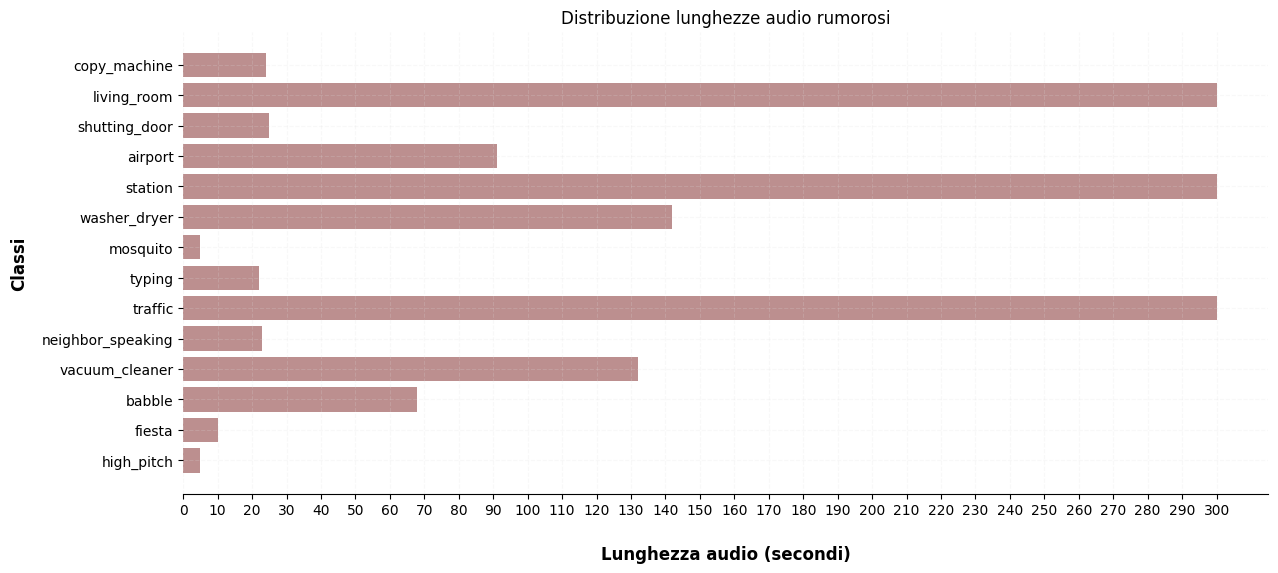

In [4]:
show_audio_length(noise_ds)

L'audio di minor lunghezza, 5 secondi, è **mosquito** insieme a **high_pitch**, mentre l'audio di maggior lunghezza, 300 secondi, è **station** insieme a **traffic** e **living_room**.

Abbiamo implementato una leggera variante della funzione samplefy che abbiamo già visto utilizzata nei notebook precedenti. Questa funzione ci permette di estrarre un audio di una classe specifica, e in questa variante possiamo specificare se ci stiamo riferendo a un audio appartenente al dataset rumoroso e uno non rumoroso.

Vogliamo visualizzare e capire graficamente quanto effettivamente sia più grande l'audio rumoroso rispetto a un audio del nostro dataset normale.

In [5]:
def samplefy(dataset, dir_label, search="audio"):
    for audio, label in dataset: # iteriamo all'interno del dataset
        label_np = label.numpy() 
        
        for i in range(len(label_np)): # controlliamo per ogni label se è uguale a quella richiesta
            if search == "audio" and (audio_label_names[label_np[i]] == dir_label):
                return audio[i], audio_label_names[label_np[i]] # ci restituisce il campione con la sua etichetta
            
            if search == "noise" and (noise_label_names[label_np[i]] == dir_label):
                return audio[i], noise_label_names[label_np[i]]

In [6]:
def plot_waves(dataset_audio, label_audio, dataset_noise, label_noise):
    audio, label_audio = samplefy(train_ds, label_audio)
    noise, label_noise = samplefy(noise_ds, label_noise, search="noise")
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))  # aumenta la dimensione della figura
    fig.tight_layout(pad=3.0)  # aggiungi padding tra i subplot

    # audio normale
    # label e titolo
    ax[0].set_title('Classe audio: ' + label_audio)
    ax[0].set_ylabel('Ampiezza', fontweight="semibold")
    ax[0].set_xlabel('Frame', fontweight="semibold")
    # rimuoviamo i limiti dei plot
    ax[0].spines["right"].set_visible(False)
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["left"].set_visible(False)
    # griglia
    ax[0].grid(True, color="gainsboro", linestyle="--", alpha=0.5)
    ax[0].plot(audio, color="indianred")
    
    # audio noise
    # label e titolo
    ax[1].set_title('Classe audio rumoroso: ' + label_noise)
    ax[1].set_ylabel('Ampiezza', fontweight="semibold")
    ax[1].set_xlabel('Frame', fontweight="semibold")
    # rimuoviamo i limiti dei plot
    ax[1].spines["right"].set_visible(False)
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["left"].set_visible(False)
    # griglia
    ax[1].grid(True, color="gainsboro", linestyle="--", alpha=0.5)
    ax[1].plot(noise, color="slategray")
    # mostriamo la differenza di lunghezza
    min_value_noise = tf.reduce_min(noise) # computo il minimo
    max_value_noise = tf.reduce_max(noise) # computo il massimo

    pos_rect = np.random.randint(0, len(noise) - 16000)
    
    grandezza_audio = mpatches.Rectangle((pos_rect, min_value_noise.numpy()), 
                                         width=16000, height=max_value_noise.numpy() + np.abs(min_value_noise.numpy()), 
                                         color='burlywood', alpha=0.95)
    ax[1].add_patch(grandezza_audio)
    
    plt.show()

    fig, ax = plt.subplots(figsize=(14, 4)) 

    # calcolo l'ampiezza massima dell'audio rumoroso
    max_amplitude_audio = np.max(np.abs(audio))
    max_amplitude_noise = np.max(np.abs(noise))
    # calcolo un noise factor che varia a seconda dell'ampiezza massima di entrambi gli audio
    noise_factor = max_amplitude_audio / max_amplitude_noise
    noise_factor = min(noise_factor, 1.0)
    
    ax.plot(noise[pos_rect:pos_rect + 16000] * noise_factor, color="slategray", alpha=0.8, label="Rumore")
    ax.plot(audio, color="indianred", alpha=0.8, label="Audio")
    # rimuoviamo i limiti dei plot
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    # label e titolo
    ax.set_title("Audio originale + audio rumoroso")
    ax.set_ylabel('Ampiezza', fontweight="semibold")
    ax.set_xlabel('Frame', fontweight="semibold")
    # legenda
    ax.legend()
    # griglia
    ax.grid(True, color="gainsboro", linestyle="--", alpha=0.5)

    plt.show()

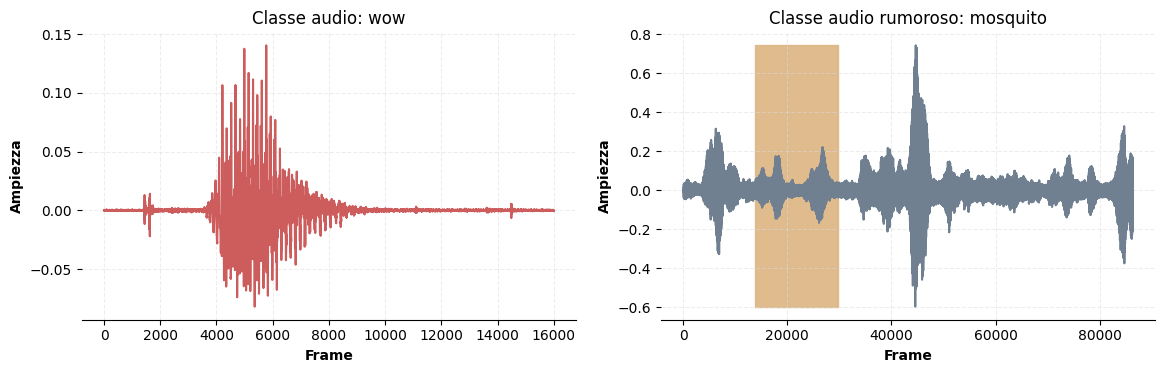

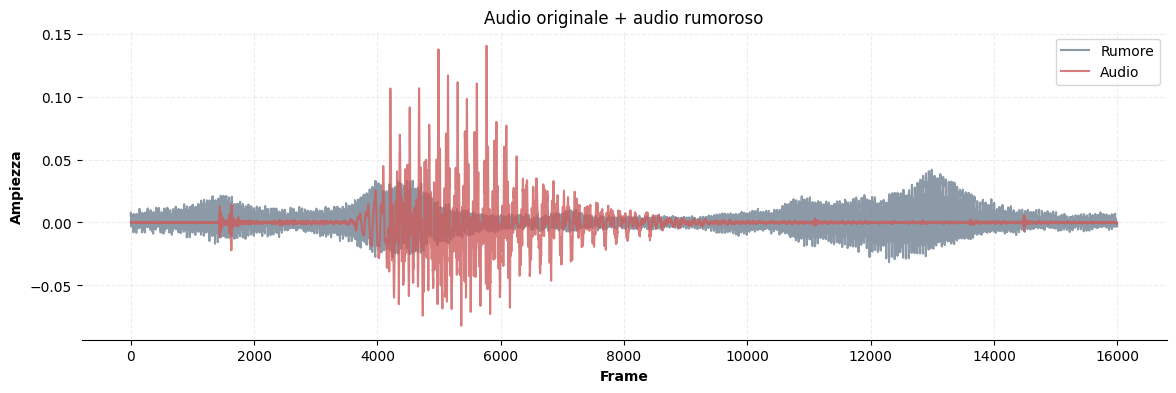

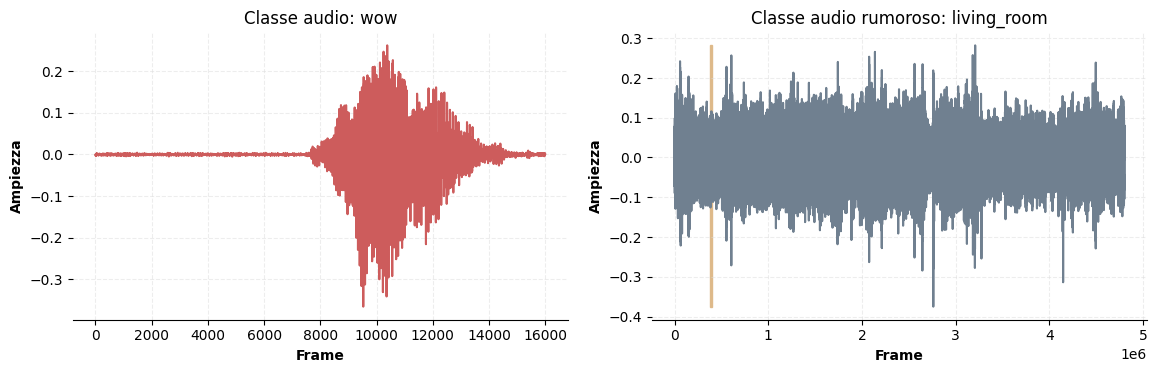

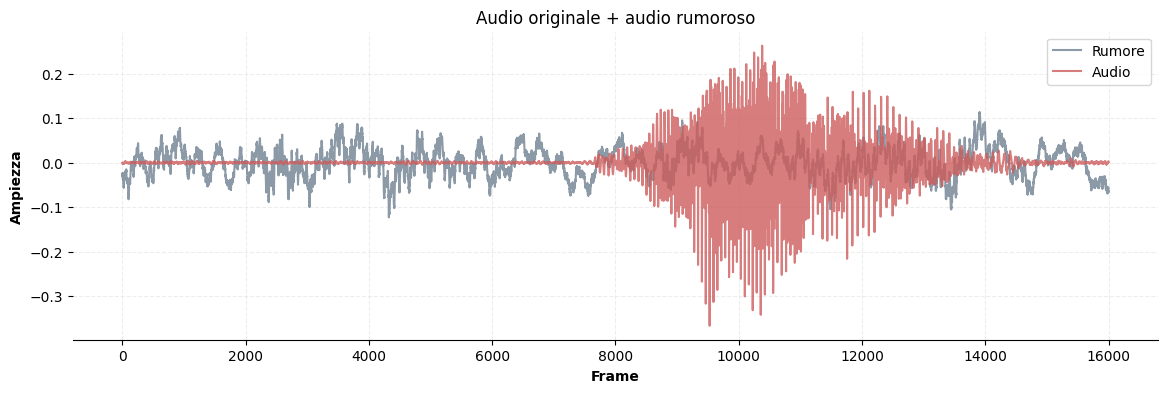

In [7]:
plot_waves(train_ds, "wow", noise_ds, "mosquito")
plot_waves(train_ds, "wow", noise_ds, "living_room")

Abbiamo preso in considerazione due audio del dataset rumoroso, rispettivamente il più corto (sopra) e il più lungo (sotto) del dataset. 
Mettendo a confronto essi con uno dei nostri comandi, si può notare quanto i primi siano di lunghezza molto maggiore. Per avere un'idea ancora più chiara, viene rappresentato con un rettangolo colorato la lunghezza dell'audio del dataset originale.

Di seguito è presente un grafico con l'audio che aspiriamo ad ottenere. Il risultato non deve essere inteso come definitivo, ma serve a comprendere meglio l'idea di ciò che stiamo implementando.

Ogni audio rumoroso viene adattato utilizzando un `noise_factor`, il quale varia in funzione dell'ampiezza massima di entrambi gli audio. Questo noise_factor è essenziale per evitare che un audio sovrasti completamente l'altro, assicurando che entrambi gli audio siano udibili. In questo modo, si riduce significativamente il rischio che uno dei due audio diventi inascoltabile.

I nuovi dati necessitano quindi di essere processati prima di utilizzarli nel nostro compito di data augmentation. 

### Taglio degli audio rumorosi
Procediamo a tagliare gli audio rumorosi così da renderli tutti di un secondo. Per fare ciò utilizzeremo la funzione `cut_audios`, che prende in input un **dataset** e la **lunghezza in frame** che vogliamo ottenere.

In [8]:
def cut_audios(dataset, length):
    new_audios = [] # inizializziamo una lista dove inseriremo i nostri audio tagliati
    labels = []
    
    # iteriamo nel dataset
    for audio, label in dataset:
        # tagliamo l'audio ad un secondo e lo appendiamo a una lista 
        labels.append(label.numpy())
        
        audio = tf.reshape(audio, [-1])[np.shape(audio)[1]//2:np.shape(audio)[1]//2 + length]
        new_audios.append(audio.numpy()) # convertiamo in array per poterli modificare
        
    return new_audios, labels

Carpiamo le informazioni dagli audio tagliandoli a partire dalla metà della lunghezza. Questa scelta è stata fatta perché alcuni audio non hanno rumori utili nei primi secondi. Quando chiamiamo questa funzione, passiamo come argomenti il dataset da cui prendere i dati e la lunghezza dell'audio desiderata, nel nostro caso passiamo **noise_ds** e **16000**, che corrisponde a 1 secondo. 

In [9]:
cut_noise_audios, cut_noise_labels = cut_audios(noise_ds, 16000)

Dopo aver tagliato gli audio, possiamo permetterci di ascoltarli tutti essendo soltanto 14. Utilizzeremo la funzione `display_audios_grid` per mostrarli in una griglia 5 x 3.

In [10]:
def display_audios_grid(audios, sample_rate=16000, clips_per_row=3):
    html = "<table>"
    for index, audio in enumerate(audios):
        if index % clips_per_row == 0:
            if index > 0:
                html += "</tr>"
            html += "<tr>"
        html += f"<td>{Audio(audio, rate=sample_rate)._repr_html_()}</td>"
    html += "</tr></table>"
    
    display(HTML(html))

In [11]:
display_audios_grid(cut_noise_audios)

Le scelte fatte ci hanno permesso di ottenere file con una quantità di rumore accettabile. 
Mostriamoli anche graficamente attraverso la funzione `show_noise_audios`, al quale passiamo il set di dati tagliati.

In [12]:
def show_noise_audios(noise_dataset):
    rows = 5
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 10))
    plt.tight_layout(pad=3.0)
    
    for index, noise in enumerate(noise_dataset):
        row = index // cols
        col = index % cols
    
        ax = axes[row][col]
    
        label = noise_label_names[int(cut_noise_labels[index][0])]

        # label
        ax.set_title(f"Classe: {label}")
        ax.set_ylabel('Ampiezza', fontweight="bold")
        ax.set_xlabel('# frame', fontweight="bold")
        # plot
        ax.plot(noise, color="indianred")

        # rimuoviamo i limiti dei plot
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)
        ax.grid(True, color="gainsboro", linestyle="--", alpha=0.5)
        
    plt.show()

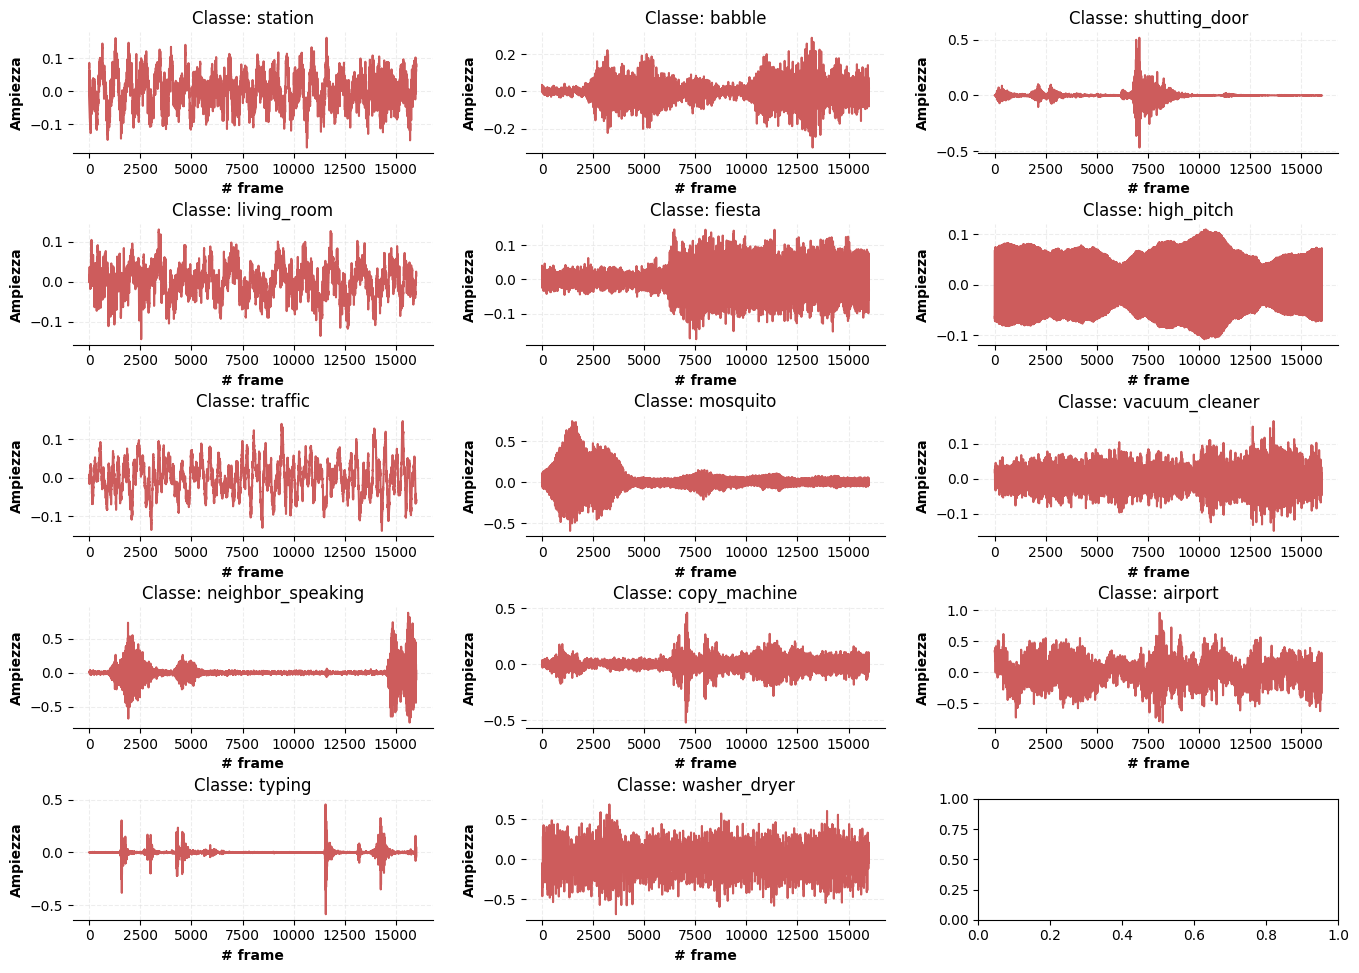

In [13]:
show_noise_audios(cut_noise_audios)

## Unione del rumore ai nostri file audio
Eseguito il pre processamento possiamo procedere alla sovrapposizione del rumore ai comandi. 

La seguente funzione si occuperà di sovrapporre gli audio dei due dataset, sommando ad ogni comando uno dei rumori scelto in modo casuale. Il risultato sarà una lista di vettori che passeremo alla funzione `create_mixed_ds` per trasformarla in un dataset di tensori, utilizzabile dai modelli tensorflow. 

Anche questa funzione applica un **noise_factor** nello stesso modo che abbiamo visto prima.

In [14]:
def mix_audios(original_audios, noise_audios):
    mixed_dataset = [] # inizializziamo la lista dove inseriremo gli audio uniti al rumore

    original_audios = original_audios.unbatch() # il nostro training set ha una batch_size di 32, per rendere il processo più semplice unbatchiamo
    
    # per ogni audio del dataset originale
    for audio, label in original_audios:    
        audio = np.squeeze(audio, axis=-1) # rimuoviamo l'ultima asse inutile (quella dei canali)
        
        # Scegliamo in modo randomico un audio dalla lista degli audio rumorosi
        noise_sample = random.choice(noise_audios)

        # calcolo l'ampiezza massima dell'audio rumoroso
        max_amplitude_audio = np.max(np.abs(audio))
        max_amplitude_noise = np.max(np.abs(noise_sample))
        # calcolo un noise factor che varia a seconda dell'ampiezza massima di entrambi gli audio
        noise_factor = max_amplitude_audio / max_amplitude_noise
        noise_factor = min(noise_factor, 1.0)
        
        noise_sample = noise_sample * noise_factor
        
        mixed_audio = audio + noise_sample # uniamo l'audio original al rumore

        # aggiungiamo l'audio con noise alla lista
        mixed_dataset.append((mixed_audio, label))

    return mixed_dataset

In [15]:
mixed_list = mix_audios(train_ds, cut_noise_audios)

Ottenuta la lista **mixed_list** possiamo procedere a creare il dataset.

In [16]:
def create_mixed_ds(dataset_list):
    audio_data = [tf.convert_to_tensor(audio, dtype=tf.float32) for audio, label in dataset_list]
    labels = [label for _, label in dataset_list]

    mixed_train_ds = tf.data.Dataset.from_tensor_slices((audio_data, labels))
    return mixed_train_ds

In [17]:
mixed_train_ds = create_mixed_ds(mixed_list)

Creato il dataset mostriamo alcuni esempi di audio con i comandi a cui è stato applicato il rumore. Ne ascolteremo sei (6).

In [18]:
def display_audios_grid(audios_labels, sample_rate=16000, clips_per_row=3, rows=2):
    html = "<table>"
    count = 0
    
    for index, (audio, label) in enumerate(audios_labels):
        if count >= rows * clips_per_row:
            break
        if index % clips_per_row == 0:
            if index > 0:
                html += "</tr>"
            html += "<tr>"
        
        html += f"""
                <td style="text-align: center;">
                    <b style="margin-bottom: 10px;">{str("Classe: ") + audio_label_names[label]}</b>
                    <br>
                    <div style="margin-top: 10px">
                        {Audio(audio, rate=sample_rate)._repr_html_()}
                    </div>
                </td>"""
        
        count += 1

    # chiude la riga
    if count > 0:
        html += "</tr>"
    
    html += "</table>"
    
    display(HTML(html))

In [19]:
display_audios_grid(mixed_train_ds)

Siamo in grado di distinguere chiaramente sia gli audio originali, sia il rumore aggiunto. 

Visualizziamo graficamente gli stessi audio appena ascoltati.

In [20]:
def show_mixed_audios(dataset):
    rows = 2
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(14, 6))

    for index, (audio, label) in enumerate(dataset):
        if index == 6:
            break

        row = index // cols
        col = index % cols
    
        ax = axes[row][col]

        # nascondo i bordi del plot
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.spines["left"].set_visible(False)

        # plotto l'audio
        ax.plot(audio, color="indianred")

        # label e title
        ax.set_title(f"Classe: {audio_label_names[label]}")
        ax.set_ylabel('Ampiezza', fontweight="bold")
        ax.set_xlabel('# frame', fontweight="bold")
        
        # griglia
        ax.grid(True, color="gainsboro", linestyle="--", alpha=0.5)

    plt.tight_layout(pad=1.5)
    plt.show()
        

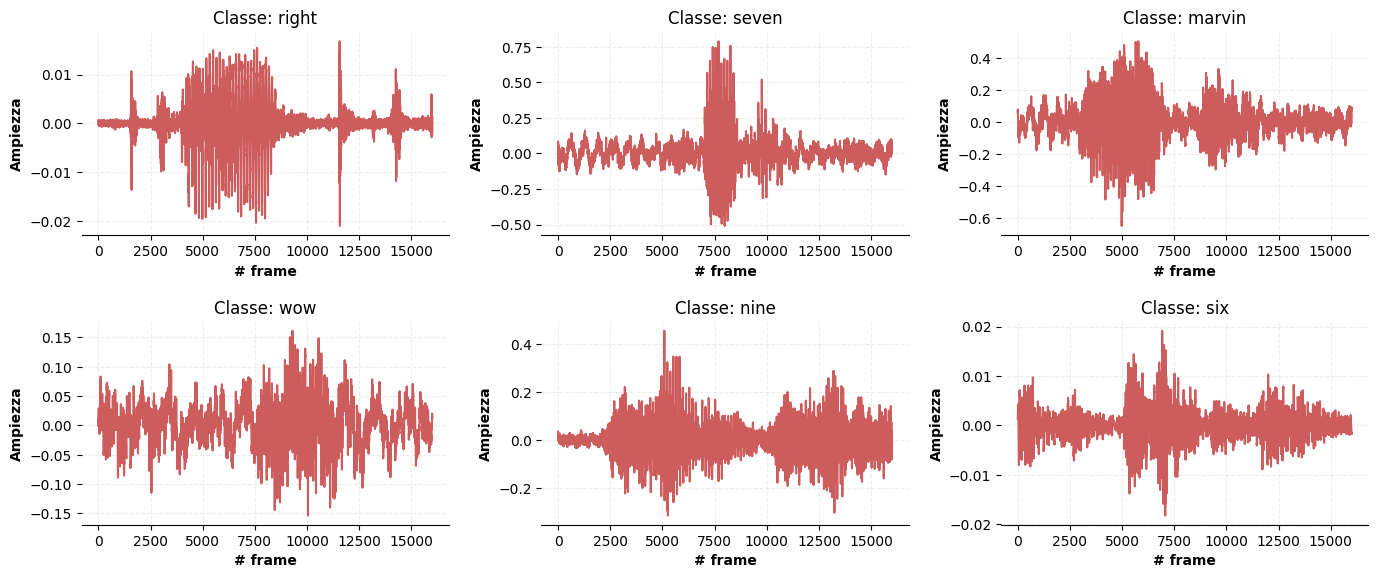

In [21]:
show_mixed_audios(mixed_train_ds)

Il grafico mostrante l'audio composto di prima è abbastanza fedele ai nuovi audio che abbiamo ottenuto.

Il modello convolutivo sarà addestrato attraverso gli spettrogrammi, perciò controlliamo se riusciamo a captare a livello visivo qualche cambiamento rispetto agli audio originali. Utilizzeremo le stesse funzioni del notebook riguardante gli spettrogrammi.

In [22]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

def get_spectrogram(waveform):
    # applichiamo la short-time Fourier transorm
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    
    return spectrogram[..., tf.newaxis]

# fonte: tutorial riconoscimento audio semplice di tensorflow: https://www.tensorflow.org/tutorials/audio/simple_audio?hl=it

def get_spectrogram_dataset(dataset):
    dataset = dataset.map(lambda x, y: (get_spectrogram(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    
    return dataset

def samplefy(dataset, dir_label):
    for audio, label in dataset:
        label_np = label.numpy()
        
        for i in range(len(label_np)):
            if audio_label_names[label_np[i]] == dir_label:
                spectrogram = np.squeeze(audio[i], axis=-1)
                spectrogram = np.log(spectrogram + np.finfo(float).eps)  # aggiungiamo una piccola costante per evitare problemi con log(0)
                return spectrogram, audio_label_names[label_np[i]]

E' stato apportato un leggero cambiamento alla funzione `plot_spectrograms` così da poter ottenere anche spettrogrammi rumorosi. Compariamo gli spettrogrammi originali con i rumorosi.

In [26]:
def plot_spectrograms(og_dataset, new_dataset):
    spectrogram1, label1 = samplefy(og_dataset, 'right')
    spectrogram2, label2 = samplefy(new_dataset, 'right')
    spectrogram3, label3 = samplefy(og_dataset, 'tree')
    spectrogram4, label4 = samplefy(new_dataset, 'tree')
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8)) # Creiamo subplot 2 x 2
    fig.tight_layout(pad=3.0)  # Aggiunge padding tra subplot
    
    # Primo spettrogramma
    im1 = ax[0, 0].imshow(spectrogram1)
    fig.colorbar(im1, ax=ax[0, 0], format='%+2.0f dB')
    ax[0, 0].set_title(f"Spettrogramma originale classe: {label1}")
    
    # Secondo spettrogramma
    im2 = ax[0, 1].imshow(spectrogram2)
    fig.colorbar(im2, ax=ax[0, 1], format='%+2.0f dB')
    ax[0, 1].set_title(f"Spettrogramma con rumore classe: {label2}")
    
    # Terzo spettrogramma
    im3 = ax[1, 0].imshow(spectrogram3)
    fig.colorbar(im3, ax=ax[1, 0], format='%+2.0f dB')
    ax[1, 0].set_title(f"Spettrogramma originale classe: {label3}")
    
    # Quarto spettrogramma
    im4 = ax[1, 1].imshow(spectrogram4)
    fig.colorbar(im4, ax=ax[1, 1], format='%+2.0f dB')
    ax[1, 1].set_title(f"Spettrogramma con rumore classe: {label4}")

    plt.show()

In [24]:
# metto a posto i dataset che andrò a utilizzare
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
mixed_train_ds = mixed_train_ds.batch(32)
mixed_train_ds = mixed_train_ds.shuffle(True)

# ottengo i dataset degli spettrogrammi
train_ds = get_spectrogram_dataset(train_ds)
mixed_train_ds = get_spectrogram_dataset(mixed_train_ds)

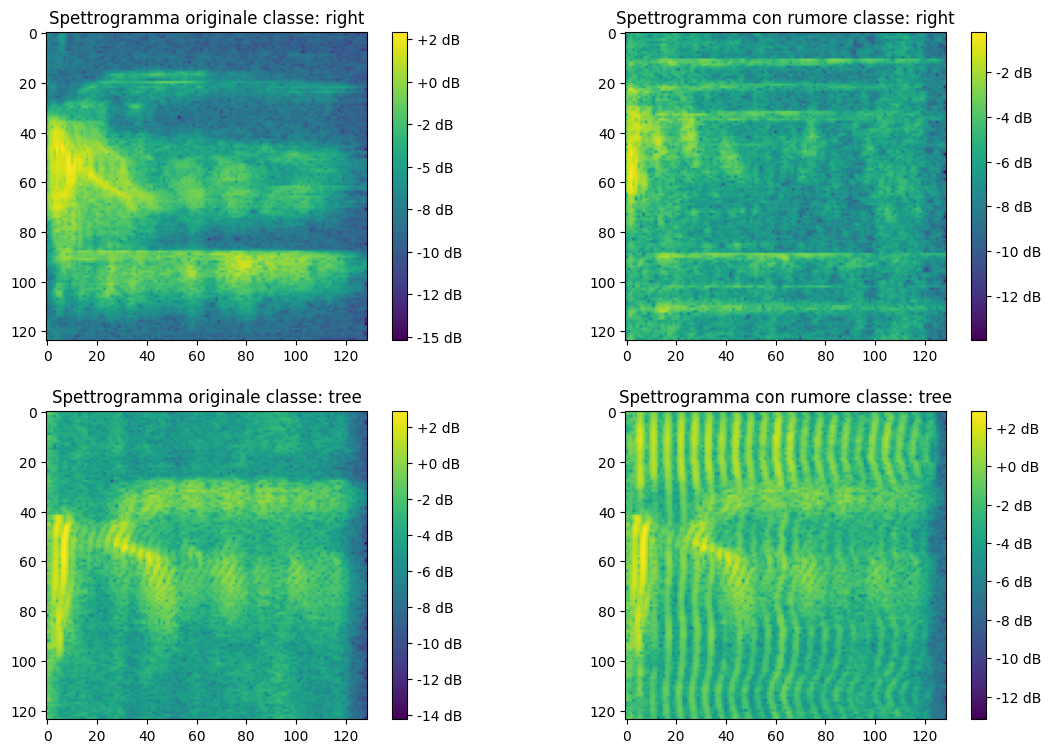

In [29]:
# plotto gli spettrogrammi
plot_spectrograms(train_ds, mixed_train_ds)

L'audio originale e con rumore non sono lo stesso, ma è appartenente alla stessa classe. Riusciamo a notare facilmente il rumore aggiunto negli spettrogrammi sulla destra.